In [2]:
import os
import glob
import numpy as np

from scipy.spatial.distance import euclidean
from scipy import signal
from scipy.signal import savgol_filter

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (16, 3.5)
plt.rcParams['figure.dpi'] = 150

import warnings
warnings.filterwarnings('ignore')

In [3]:
from peakdetect import peakdetect

def peak_detection(array, look_ahead=500, diff_threshold=0.01):
    # lookahead is the distance to look ahead from a peak to determine if it is the actual peak.
    peaks = peakdetect(array, lookahead=look_ahead, delta=diff_threshold)
    higherPeaks = np.array(peaks[0])
    lowerPeaks = np.array(peaks[1])

    peak_lists_ = np.concatenate([higherPeaks[:, 0], lowerPeaks[:, 0]], axis=0)

    return peak_lists_

def change_slope_detection(array, window=500, poly=3, deriv=3):
    der2 = savgol_filter(dary_step, window_length=window, polyorder=poly, deriv=deriv)
    max_der2 = np.max(np.abs(der2))
    large = np.where(np.abs(der2) > max_der2/2)[0]
    gaps = np.diff(large) > window
    begins = np.insert(large[1:][gaps], 0, large[0])
    ends = np.append(large[:-1][gaps], large[-1])
    changes = ((begins+ends)/2).astype(np.int32)
    
    return changes

def butter_highpass(cut=0.5, order=5):
    b, a = signal.butter(order, cut, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cut, order=5):
    b, a = butter_highpass(cut, order=order)
    y = signal.filtfilt(b, a, data, axis=0)
    return y

In [5]:
path_to_dataset = '/Users/hoanglinh96nl/Library/CloudStorage/OneDrive-NTHU/Projects and Papers/ASE_PHM_WireBonding/dataset'
data_date = '10_DAQ_20221227'
folder_path = os.path.join(path_to_dataset, data_date)
program = os.listdir(folder_path)
print(program)

['8、RLK4344AST', '1、UMT2345OST02', 'Set_Parameter.xlsx', '3、ENM0027FST', '9、RLK4892OST02', '5、EPS2053OTK', '4、EPS1454BTK', '7、MEA1112OCT02', '6、RIC0060OTT', '2、RLK3858AST']


In [6]:
program_csv = os.path.join(folder_path, program[5], 'One_Die')
csv_files = glob.glob(os.path.join(program_csv, "*.csv"))

ls = []
for csv_file in csv_files:
    ls.append(pd.read_csv(csv_file, header=None, index_col=None).drop([0, 1, 2, 5], axis=1))
all_csv = pd.concat(ls, ignore_index=True)
all_csv.columns = ['Z', 'Piezo']

In [7]:
df = pd.read_csv(data_file, header=None).drop([0, 1, 2, 5], axis=1)
# df = pd.read_csv(data_file, header=None).drop(['X', 'Y'], axis=1)

NameError: name 'data_file' is not defined

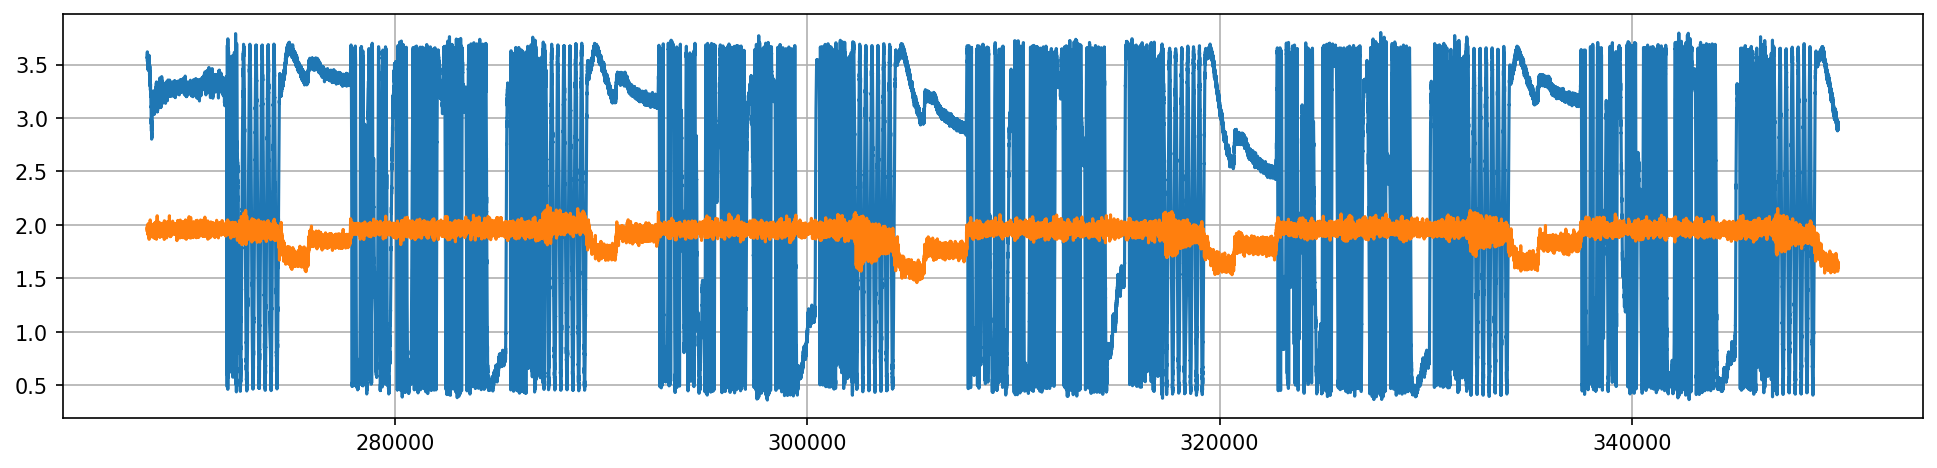

In [42]:
start, end = 268000, 350000
plt.plot(all_csv[start: end])
plt.show()

### Crop follow piezo data

In [8]:
crop_idx = []
dary_list = []

dary = df[4].copy().rolling(window=200, min_periods=1).mean()
dary -= np.average(dary)

# using cumsum method
dary_step = np.cumsum(dary)
dary_step = (dary_step - dary_step.min()) / (dary_step.max() - dary_step.min())
# peak_lists = peak_detection(dary_step, diff_threshold=0.001)
crop_idx.extend(np.array(peak_lists))
dary_list.extend(dary_step)

crop_idx = np.sort(np.array(crop_idx, dtype=int))

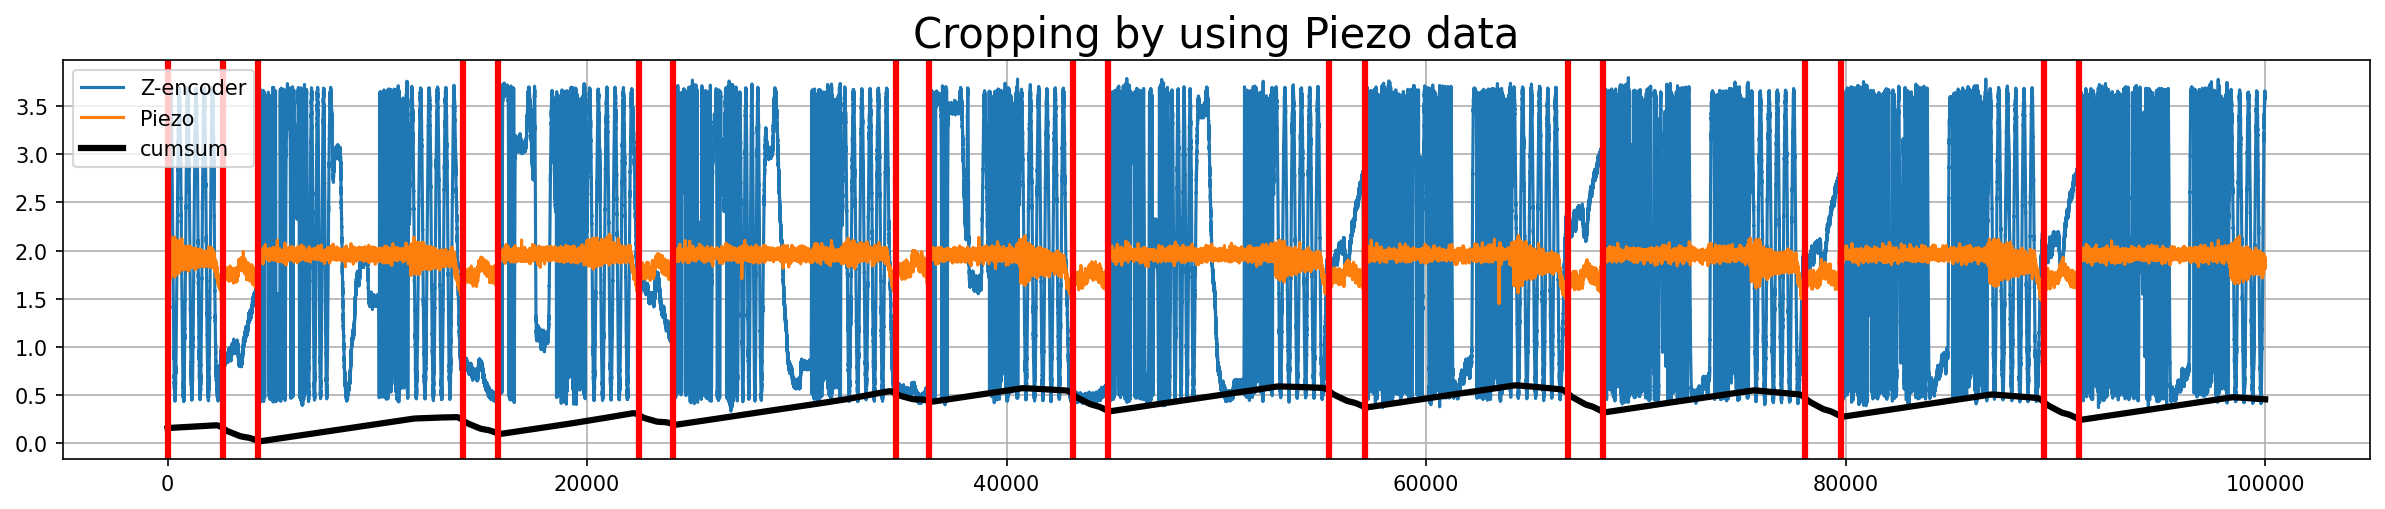

In [10]:
start, end = 0, 100000
crop_idx = change_slope_detection(dary_step, 500, 3, 3)
crop_idx_custom_range = crop_idx[(crop_idx > start) & (crop_idx < end)]
crop_idx_custom_range = np.insert(crop_idx_custom_range, 0, start)

plt.plot(df[3][start: end], label='Z-encoder')
plt.plot(df[4][start: end], label='Piezo')
plt.plot(range(start, end), dary_list[start: end], c='black', linewidth=3.0, label='cumsum')
for idx in crop_idx_custom_range:
    plt.axvline(idx, c='r', linewidth=3.0)
    
plt.title('Cropping by using Piezo data', fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()